Anika Slizewski

Astr 480

Reducing Imaging Data and Photometry

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
from astropy.modeling import models
import bottleneck as bn 
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from photutils import datasets, Background2D, MedianBackground, SExtractorBackground,make_source_mask,DAOStarFinder,CircularAperture,CircularAnnulus
from astropy.stats import SigmaClip, biweight_location,sigma_clipped_stats, mad_std

from astropy.visualization import SqrtStretch, LogStretch, SinhStretch, LinearStretch
from astropy.visualization.mpl_normalize import ImageNormalize


DATA REDUCTION:
With ccdproc

In [2]:
image_list=glob.glob("/Users/anikaslizewski/480/arcsat2019/*.fits")  

Arcsat info (manuf values, not calculated):

In [3]:
gain=1.25 *u.electron/u.adu
rnoise= 11.8 *u.electron

Functions used later in analysis:

In [4]:
norm=ImageNormalize(stretch=LogStretch())
sigmaclip=SigmaClip(3.0)
def avg_over_images(masked_arr, axis=0):
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)
def bn_median(masked_array, axis=None):
    
    data = masked_array.filled(fill_value=np.NaN)
    med = bn.nanmedian(data, axis=axis)
    return np.ma.array(med, mask=np.isnan(med))

For loop to extract image type for bias, dark, flat, and light frames, 
then further extracting the exposure times and filters to limit darks and flats to the same exposure times,
and filtering flats and light frames to lists of each filter.

In [5]:
imagedata=[]
imagetypes=[]
imgtime=[]
bias_list=[]
flat_list=[]
dark_list1=[]
pics=[]
image_u=[]
image_g=[]
image_r=[]
image_i=[]
image_z=[]
image_h=[]
flats_u=[]
flats_g=[]
flats_r=[]
flats_r=[]
flats_i=[]
flats_z=[]
flats_h=[]

for filename in image_list:
    
    file=CCDData.read(filename,unit='adu')
    data=file.data
    imagedata.append(data)
    imgtyp=file.header['imagetyp'].strip()
    imgtime=file.header['exptime']

    if imgtyp in ['Bias Frame', 'BIAS']:
        bias_list.append(file)
        print(np.mean(file))
    if imgtyp in ['Flat Frame','FLAT']:
        flat_list.append(file) 
        
    if imgtyp in ['Dark Frame','DARK']:
        dark_list1.append(file)
        
    if imgtyp in ['Light Frame']:
        pics.append(file)
        
print('Above are the mean counts (in ADUs) for each bias frame.')

dark_list=[]
for file in dark_list1:
    imgtime=file.header['exptime']
    if imgtime==120.0:
        dark_list.append(file)
            
            
for filename in flat_list:
    header=filename.header
    flter=header['filter']

    if flter in ['sdss_u']:
        flats_u.append(file)
    if flter in ['sdss_g']:
        flats_g.append(file)
    if flter in ['sdss_r']:
        flats_r.append(file)
    if flter in ['sdss_i']:
        flats_i.append(file)
    if flter in ['sdss_z']:
        flats_z.append(file)
    if flter in ['halpha']:
        flats_h.append(file)
            

for file in pics:
    header=file.header
    flter=header['filter']
    if flter in ['sdss_u']:
        image_u.append(file)
    if flter in ['sdss_g']:
        image_g.append(file)
    if flter in ['sdss_r']:
        image_r.append(file)
    if flter in ['sdss_i']:
        image_i.append(file)
    if flter in ['sdss_z']:
        image_z.append(file)
    if flter in ['halpha']:
        image_h.append(file)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


1310.9541902542114
1310.9803161621094
1310.98957157135
1310.969250679016
1310.531002998352
1310.9446687698364
Above are the mean counts (in ADUs) for each bias frame.


Function for arrays of basic value statistics of the data:

In [6]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

Using ccdproc's Combiner to make master lists, with average values of each file in the array:

In [7]:
biases = ccdproc.Combiner(bias_list)
master_bias = biases.average_combine()
print('The mean ADU count for the master bias is',np.mean(master_bias))
bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(master_bias))

The mean ADU count for the master bias is 1310.8948334058123


In [8]:
darks = ccdproc.Combiner(dark_list)
master_dark = darks.average_combine()
print('The mean ADU count for the master dark is',np.mean(master_dark))
dark_min, dark_max, dark_mean, dark_std = imstats(np.asarray(master_dark))

The mean ADU count for the master dark is 1372.6973556518556


Making master flats, by filter, and by subtracting the bias and dark per file before combining:

In [9]:
sd_flat_u =[]
sd_flat_g =[]
sd_flat_r =[]
sd_flat_i =[]
sd_flat_z =[]
sd_flat_h =[]


for file in flats_u:
    exptime=file.header['exptime']*u.second
    sub_b=ccdproc.subtract_bias(file,master_bias)
    sub=ccdproc.subtract_dark(sub_b, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    sd_flat_u.append(sub)
flat_combiner = ccdproc.Combiner(sd_flat_u)
flat_combiner.sigma_clipping(func=med_over_images)

master_flat_u = flat_combiner.median_combine(median_func=bn_median)


for file in flats_g:
    exptime=file.header['exptime']*u.second
    sub_b=ccdproc.subtract_bias(file,master_bias)
    sub=ccdproc.subtract_dark(sub_b, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    sd_flat_g.append(sub)
flat_combiner = ccdproc.Combiner(sd_flat_g)
flat_combiner.sigma_clipping(func=med_over_images)

master_flat_g = flat_combiner.median_combine(median_func=bn_median)


for file in flats_r:
    exptime=file.header['exptime']*u.second
    sub_b=ccdproc.subtract_bias(file,master_bias)
    sub=ccdproc.subtract_dark(sub_b, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    sd_flat_r.append(sub)
flat_combiner = ccdproc.Combiner(sd_flat_r)
flat_combiner.sigma_clipping(func=med_over_images)

master_flat_r = flat_combiner.median_combine(median_func=bn_median)


for file in flats_i:
    exptime=file.header['exptime']*u.second
    sub_b=ccdproc.subtract_bias(file,master_bias)
    sub=ccdproc.subtract_dark(sub_b, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    sd_flat_i.append(sub)
flat_combiner = ccdproc.Combiner(sd_flat_i)
flat_combiner.sigma_clipping(func=med_over_images)

master_flat_i = flat_combiner.median_combine(median_func=bn_median)


for file in flats_z:
    exptime=file.header['exptime']*u.second
    sub_b=ccdproc.subtract_bias(file,master_bias)
    sub=ccdproc.subtract_dark(sub_b, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    sd_flat_z.append(sub)
flat_combiner = ccdproc.Combiner(sd_flat_z)
flat_combiner.sigma_clipping(func=med_over_images)

master_flat_z = flat_combiner.median_combine(median_func=bn_median)


for file in flats_h:
    exptime=file.header['exptime']*u.second
    sub_b=ccdproc.subtract_bias(file,master_bias)
    sub=ccdproc.subtract_dark(sub_b, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    sd_flat_h.append(sub)
flat_combiner = ccdproc.Combiner(sd_flat_h)
flat_combiner.sigma_clipping(func=med_over_images)

master_flat_h = flat_combiner.median_combine(median_func=bn_median)


Calibrating each light frame, by first subtracting the bias and dark, then correcting for the flat, then correcting for gain.  The gain correction, as well as the dark correction, are not very necessary:

In [10]:
u_calibrated = []
for file in image_u:
    exp = file.header['exptime']*u.second
    sub_bias=ccdproc.subtract_bias(file,master_bias)
    sub_dark=ccdproc.subtract_dark(sub_bias, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    cor_gain = ccdproc.gain_correct(sub_dark, gain=gain)
    div_flat = ccdproc.flat_correct(cor_gain, master_flat_u)
    u_calibrated.append(div_flat)
    
u_0 = u_calibrated[0]
mean_u_0 =  np.mean(u_0)
std_u_0 = np.std(u_0)

g_calibrated = []
for file in image_g:
    exp = file.header['exptime']*u.second
    sub_bias=ccdproc.subtract_bias(file,master_bias)
    sub_dark=ccdproc.subtract_dark(sub_bias, master_dark, data_exposure=exptime, dark_exposure=120*u.second)    
    cor_gain = ccdproc.gain_correct(sub_dark, gain=gain)
    div_flat = ccdproc.flat_correct(cor_gain, master_flat_g)
    g_calibrated.append(div_flat)
    
g_0 = g_calibrated[0]
mean_g_0 =  np.mean(g_0)
std_g_0 = np.std(g_0)

r_calibrated = []
for file in image_r:
    exp = file.header['exptime']*u.second
    sub_bias=ccdproc.subtract_bias(file,master_bias)
    sub_dark=ccdproc.subtract_dark(sub_bias, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    cor_gain = ccdproc.gain_correct(sub_dark, gain=gain)
    div_flat = ccdproc.flat_correct(cor_gain, master_flat_r)
    r_calibrated.append(div_flat)
    
r_0 = r_calibrated[0]
mean_r_0 =  np.mean(r_0)
std_r_0 = np.std(r_0)

i_calibrated = []
for file in image_i:
    exp = file.header['exptime']*u.second
    sub_bias=ccdproc.subtract_bias(file,master_bias)
    sub_dark=ccdproc.subtract_dark(sub_bias, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    cor_gain = ccdproc.gain_correct(sub_dark, gain=gain)
    div_flat = ccdproc.flat_correct(cor_gain, master_flat_i)
    i_calibrated.append(div_flat)
    
i_0 = i_calibrated[0]
mean_i_0 =  np.mean(i_0)
std_i_0 = np.std(i_0)


z_calibrated = []
for file in image_z:
    exp = file.header['exptime']*u.second
    sub_bias=ccdproc.subtract_bias(file,master_bias)
    sub_dark=ccdproc.subtract_dark(sub_bias, master_dark, data_exposure=exptime, dark_exposure=120*u.second)
    cor_gain = ccdproc.gain_correct(sub_dark, gain=gain)
    div_flat = ccdproc.flat_correct(cor_gain, master_flat_z)
    z_calibrated.append(div_flat)
    
z_0 = z_calibrated[0]
mean_z_0 =  np.mean(z_0)
std_z_0 = np.std(z_0)

print(image_z)

[CCDData([[1926, 1998, 2020, ..., 1825, 1810, 1949],
         [2099, 1930, 1897, ..., 1879, 1786, 1806],
         [2063, 2039, 2304, ..., 1733, 1797, 1838],
         ...,
         [1833, 1862, 1941, ..., 2006, 1799, 1873],
         [1894, 2006, 2020, ..., 1813, 1814, 1801],
         [1894, 2022, 2002, ..., 1929, 1782, 1925]])]


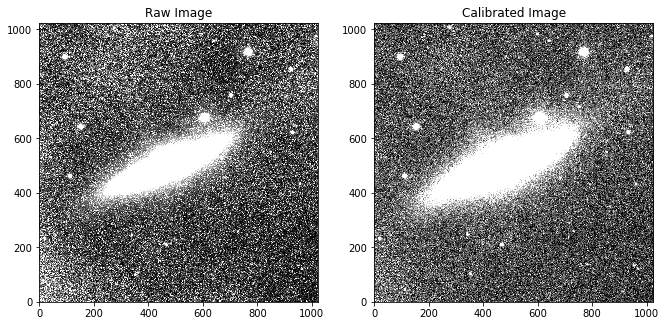

In [13]:
plt.figure(figsize=(11, 8.5))
plt.subplot(1,2,1)
plt.title('Raw Image')
plt.imshow(image_r[0],vmin=np.percentile(image_r[0], 5), vmax=np.percentile(image_r[0], 90),
           origin='lower', cmap='binary_r', interpolation='nearest')
plt.subplot(1,2,2)
plt.title('Calibrated Image')
plt.imshow(r_0, vmin=np.percentile(r_0, 5), vmax=np.percentile(r_0, 90),
           origin='lower', cmap='binary_r', interpolation='nearest');

Tadaa! This concludes today's data reduction. 

I could have made this more complicated (as well as much more simple.  For example, I could have used the fits funciton and just used numpy to do simple arithmetic to subtract the bias and dark then divide by the flat minus the bias to get the calibrated image.  I tried this out in a different code and it works too.)
The sigma clipping and normalizing also wasn't that necessary. 
The background has less variation (clouds etc) and the stars look brighter, so I think this was successful.  

SOURCES:  
1. https://ccdproc.readthedocs.io/en/latest/ccdproc/index.html
2. https://ccdproc.readthedocs.io/en/latest/ccdproc/ccddata.html
3. http://nbviewer.ipython.org/gist/mwcraig/06060d789cc298bbb08e
4. https://ccdproc.readthedocs.io/en/latest/ccdproc/reduction_toolbox.html

-----------

PHOTOMETRY

In [14]:
from photutils import datasets, Background2D, MedianBackground, SExtractorBackground,make_source_mask,DAOStarFinder,CircularAperture, CircularAnnulus
from astropy.stats import SigmaClip, biweight_location,sigma_clipped_stats, mad_std

from astropy.visualization import SqrtStretch, LogStretch, SinhStretch, LinearStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup, IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

from photutils import aperture_photometry


Using the given file 'quadRU.fits':

In [16]:
stars=CCDData.read('/Users/anikaslizewski/480/quadRU.fits',unit='adu')
stars.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1027                                                  
NAXIS2  =                 1023                                                  
EXTEND  =                    T                                                  

The image has been calibrated, but clearly needs to have the background subtracted:

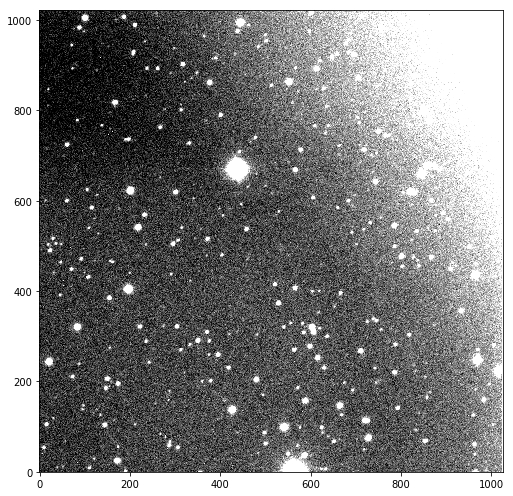

In [18]:
plt.figure(figsize=(11, 8.5))
plt.imshow(stars, vmin=np.percentile(stars, 5), vmax=np.percentile(stars, 90),
           origin='lower', cmap='binary_r', interpolation='nearest');

To start the background process, I first create a gradient:

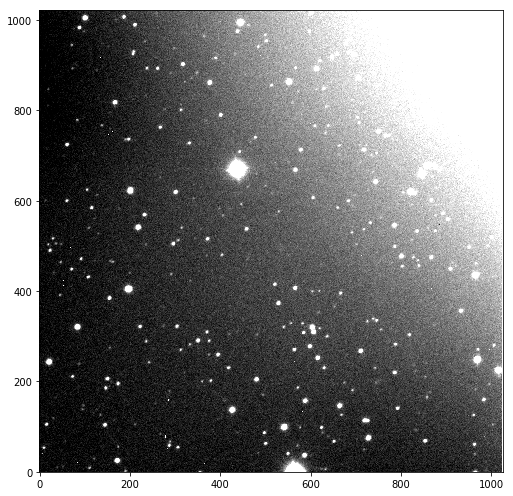

In [19]:
plt.figure(figsize=(11, 8.5))
ny, nx = stars.shape
y, x = np.mgrid[:ny, :nx]
gradient =  x * y / 5000.
stars_2 = stars + gradient
plt.imshow(stars_2, vmin=np.percentile(stars_2, 5), vmax=np.percentile(stars_2, 90),
           origin='lower', cmap='binary_r', interpolation='nearest')

Then I use MedianBackground (could also use SExtractor) to create a 2D background, plotted below:

304.29614456353397
12.544509335356228


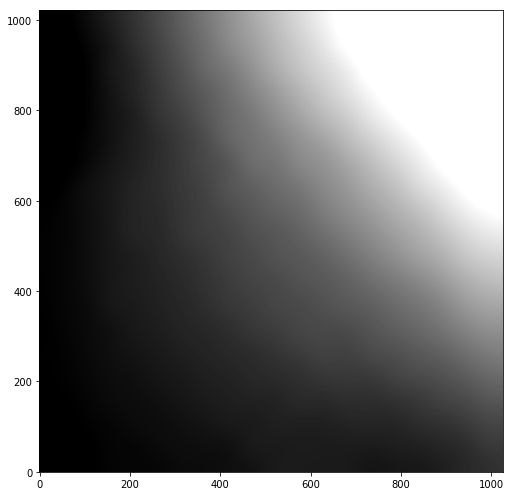

In [20]:
bkg_estimator = MedianBackground()
bkg = Background2D(stars_2, (50, 50), filter_size=(3, 3), sigma_clip=sigmaclip, bkg_estimator=bkg_estimator)

print(bkg.background_median)  
print(bkg.background_rms_median) 

plt.figure(figsize=(11,8.5))
plt.imshow(bkg.background, vmin=np.percentile(bkg.background, 5), vmax=np.percentile(bkg.background, 90),
           origin='lower', cmap='binary_r', interpolation='nearest');

Lastly, here is the fully calibrated/reduced image:

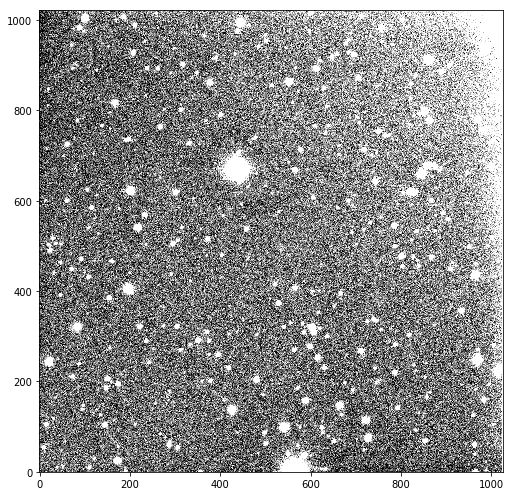

In [21]:
newstars=stars_2 - bkg.background
plt.figure(figsize=(11,8.5))
plt.imshow(newstars, vmin=np.percentile(newstars, 5), vmax=np.percentile(newstars, 90),
           origin='lower', cmap='binary_r', interpolation='nearest')

The corner is less obstructive and the sky looks more like distant stars with less in the way.  Looks good!

Now, we use DAO Star finder to find sources.  Changing the full-width-half-max and threshold change the number of stars detected:

In [22]:
mean, median, std = sigma_clipped_stats(newstars, sigma=3.0)    

daofind = DAOStarFinder(fwhm=6.0, threshold=3*std)    
sources = daofind(newstars - median)    

for col in sources.colnames: sources[col].info.format = '%.8g'

print('There are {0:.0f} stars detected.'.format(len(sources)))

mask1 = sources['peak'] > 800
goodsources=sources[mask1]

There are 726 stars detected.


For reference/ and idea of how this number might change, I decrease the fwhm:

In [23]:
mean, median, std = sigma_clipped_stats(newstars, sigma=3.0)    

daofind = DAOStarFinder(fwhm=4.0, threshold=3*std)    
sources = daofind(newstars - median)    

for col in sources.colnames: sources[col].info.format = '%.8g'

print('There are {0:.0f} stars detected, only ten larger when decreasing the fwhm by two.'.format(len(sources)))

There are 736 stars detected, only ten larger when decreasing the fwhm by two.


In [24]:
mean, median, std = sigma_clipped_stats(newstars, sigma=3.0)    

daofind = DAOStarFinder(fwhm=7.0, threshold=4*std)    
sources = daofind(newstars - median)    

for col in sources.colnames: sources[col].info.format = '%.8g'

print('There are {0:.0f} stars detected, lol!'.format(len(sources)))

There are 420 stars detected, lol!


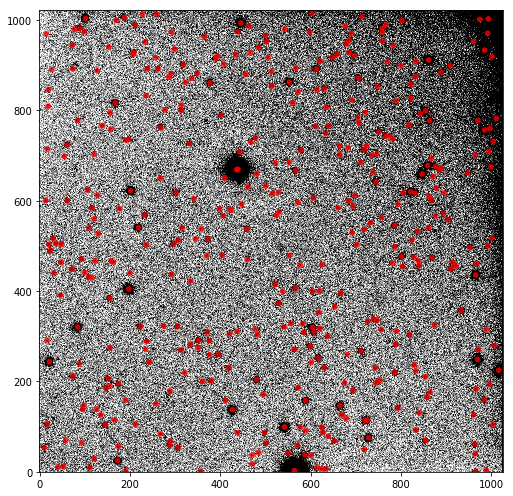

In [44]:
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=3)

plt.figure(figsize=(11,8.5))
plt.imshow(newstars, vmin=np.percentile(newstars, 5), vmax=np.percentile(newstars, 90),
           origin='lower', cmap='gray_r', interpolation='nearest')
apertures.plot(color='red', lw=3, alpha=0.8)

I can also mask the sources to only show those with higher fluxes:

In [45]:
mask_2=sources['flux']>4
goodsources=sources[mask_2]
print('There are now {0:.0f} stars (half) detected.'.format(len(goodsources)))

There are now 210 stars (half) detected.


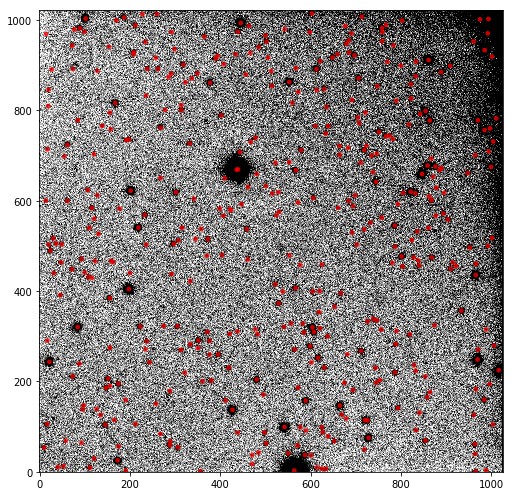

In [46]:
positions_2 = (goodsources['xcentroid'], goodsources['ycentroid'])
apertures = CircularAperture(positions, r=3)

plt.figure(figsize=(11,8.5))
plt.imshow(newstars, vmin=np.percentile(newstars, 5), vmax=np.percentile(newstars, 90),
           origin='lower', cmap='gray_r', interpolation='nearest')
apertures.plot(color='red', lw=2, alpha=0.8)

Now with the annulus function:

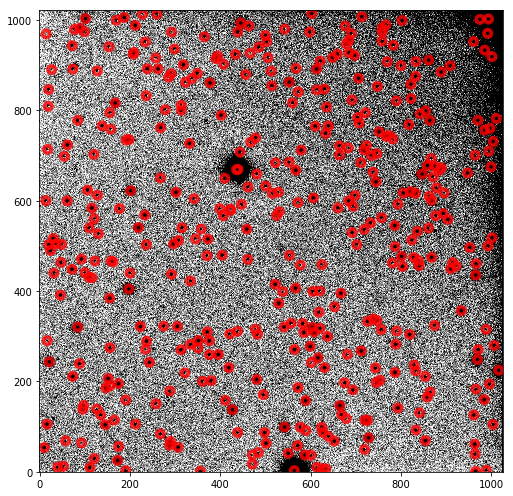

In [47]:
positions_3 = (goodsources['xcentroid'], goodsources['ycentroid'])
annulus = CircularAnnulus(positions,r_in=6,r_out=10)
plt.figure(figsize=(11,8.5))
plt.imshow(newstars, vmin=np.percentile(newstars, 5), vmax=np.percentile(newstars, 90),
           origin='lower', cmap='gray_r', interpolation='nearest')
annulus.plot(color='red',lw=2, alpha=0.8)

In the tables below, the aperture_sum_0 represents the aperture method, and aperture_sum_1 represents the annulus method:

In [48]:
apers = [apertures, annulus]
phot_table = aperture_photometry(newstars, apers)
for col in phot_table.colnames:
     phot_table[col].info.format = '%.8g' 
print(phot_table)

 id  xcenter   ycenter   aperture_sum_0 aperture_sum_1
       pix       pix                                  
--- --------- ---------- -------------- --------------
  1 356.02396 0.65796976      2408.0033     -19.751029
  2 965.46841  0.5781938      6375.8411      218.87753
  3 191.10115  2.0150893      2286.8604     -237.48532
  4  564.0213  2.1494161      1680852.4      591864.11
  5 989.11608  2.7781766      614.15672     -409.78718
  6 625.08984  6.2299115      879.61789      1869.2748
  7 633.93146   5.995922      2069.4761      434.88856
  8 111.54952  8.7631561      2543.3898      383.98287
  9 40.377211  9.8806194      937.33022     -45.402811
 10 614.13895  9.4622233      780.37344      755.67677
...       ...        ...            ...            ...
411 170.07437  999.14408      830.61303      129.19502
412 802.68461  998.53633      6910.0026      7865.2164
413 974.93218  1001.1235      1957.5821      9446.1934
414 993.84176  1002.0519      4345.5378      11839.357
415 101.84

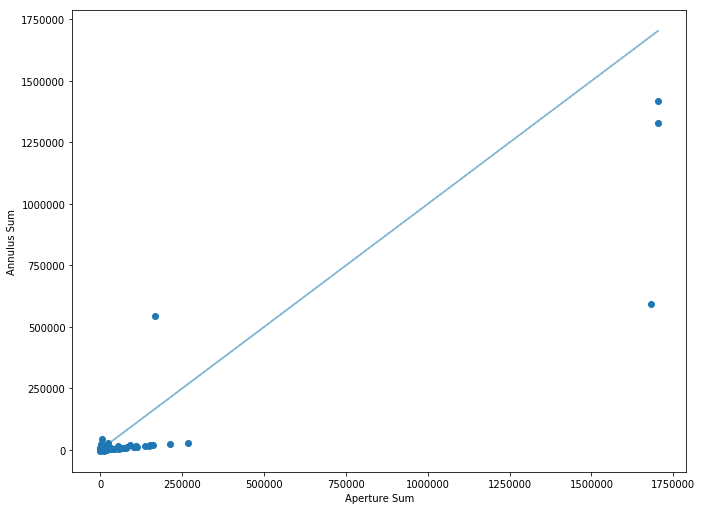

In [49]:
x=phot_table['aperture_sum_0']
y=phot_table['aperture_sum_1']
plt.figure(figsize=(11,8.5))
plt.scatter(x,y)
plt.plot(x,x,alpha=0.5,linestyle='-')
plt.xlabel('Aperture Sum')
plt.ylabel('Annulus Sum');

In [50]:
bkg_mean = phot_table['aperture_sum_1'] / annulus.area()
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'
print(phot_table)  

 id  xcenter   ycenter   aperture_sum_0 aperture_sum_1 residual_aperture_sum
       pix       pix                                                        
--- --------- ---------- -------------- -------------- ---------------------
  1 356.02396 0.65796976      2408.0033     -19.751029             2410.7807
  2 965.46841  0.5781938      6375.8411      218.87753             6345.0615
  3 191.10115  2.0150893      2286.8604     -237.48532             2320.2568
  4  564.0213  2.1494161      1680852.4      591864.11             1597621.5
  5 989.11608  2.7781766      614.15672     -409.78718             671.78304
  6 625.08984  6.2299115      879.61789      1869.2748             616.75112
  7 633.93146   5.995922      2069.4761      434.88856             2008.3199
  8 111.54952  8.7631561      2543.3898      383.98287             2489.3922
  9 40.377211  9.8806194      937.33022     -45.402811             943.71499
 10 614.13895  9.4622233      780.37344      755.67677              674.1064

In [51]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.psf import BasicPSFPhotometry
from astropy.table import Table
from photutils.psf import IterativelySubtractedPSFPhotometry


Using PSF instead of aperture, I tried the BasicPSFPhotometry but could not get it to work.  So, I used IterativelySubtractedPSFPhotometry:

In [52]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(newstars)

daogroup = DAOGroup(4.0*gaussian_sigma_to_fwhm)
bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=2.0)


photometry = IterativelySubtractedPSFPhotometry(finder=daofind,
                                                 group_maker=daogroup,
                                                 bkg_estimator=bkg,
                                                 psf_model=psf_model,
                                                 fitter=fitter,
                                                 niters=1, fitshape=(11,11))
result_tab = photometry(image=newstars)
residual_image = photometry.get_residual_image()


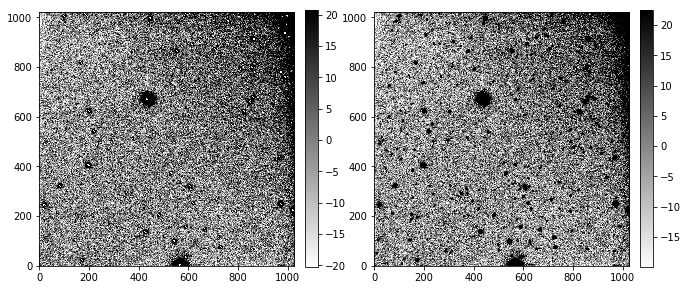

In [53]:
plt.figure(figsize=(11,8.5))
plt.subplot(1,2,1)
plt.imshow(residual_image, vmin=np.percentile(residual_image, 5), vmax=np.percentile(residual_image, 90),
           origin='lower', cmap='gray_r', interpolation='nearest')
plt.colorbar(orientation='vertical', fraction=0.046, pad=0.04)
plt.subplot(1,2,2)
plt.imshow(newstars, vmin=np.percentile(newstars, 5), vmax=np.percentile(newstars, 90),
           origin='lower', cmap='gray_r', interpolation='nearest')
plt.colorbar(orientation='vertical', fraction=0.046, pad=0.04);

The residual image should be more uniform (all left when removing the stars), but it has visibly done the job and removed many when comparing next to the original image. 

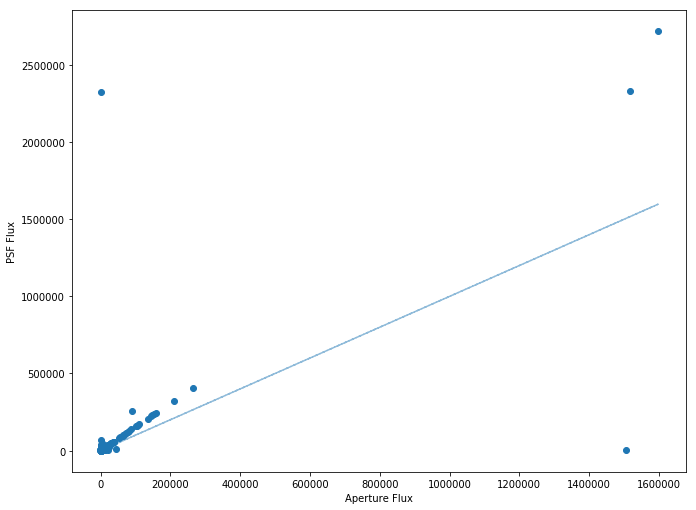

In [60]:
x=phot_table['residual_aperture_sum']
y=result_tab['flux_fit']
plt.figure(figsize=(11,8.5))
plt.xlabel('Aperture Flux')
plt.ylabel('PSF Flux');
plt.scatter(x,y)
plt.plot(x,x,alpha=0.5,linestyle='--')


The PSF method has overall higher flux total than the Aperture method.

That's all, folks!

Sources:

1. https://photutils.readthedocs.io/en/stable/background.html
2. https://photutils.readthedocs.io/en/stable/detection.html
3. https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html
4. https://photutils.readthedocs.io/en/stable/psf.html
        
    